# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()


## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
def load_model(weights =models.ResNet152_Weights.IMAGENET1K_V2):
    model = models.resnet152(weights=weights)
    transforms = weights.transforms()
    size_parameters = 512
    model.fc = nn.Sequential(
        #nn.Linear(model.fc.in_features, size_parameters),
        #nn.ReLU(),
        #nn.Linear(size_parameters, size_parameters),
        #nn.ReLU(),
        #nn.Linear(size_parameters, size_parameters),
        #nn.ReLU(),
        nn.Linear(model.fc.in_features, 832), # 13 pieces types 8*8*13
        nn.Sigmoid()
    )
    # black 
    model.to(device)
    return model,transforms
model, transforms = load_model()

Using cuda device


In [6]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [7]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.zeros((len(self.file_names), 8,8, 13), dtype=torch.float32)
        for i in range(8):
            for j in range(8):
                self.boards[:, i, j, 12] = 1 # initialize empty board with 1s for empty squares
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row][col][12] =0
            self.boards[idx][row][col][piceId] =1
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board




In [8]:
train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)

Number of train images: 6479
Number of valid images: 2192


In [9]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([16, 224, 224, 3])
['-', 'K', '-', 'B', 'R', 'R', '-', '-']
['P', 'P', 'P', 'N', '-', '-', 'P', '-']
['-', '-', 'N', 'P', 'B', '-', 'Q', 'P']
['-', '-', '-', 'n', 'P', '-', '-', '-']
['-', '-', '-', '-', 'p', 'p', '-', 'p']
['-', '-', '-', '-', '-', '-', 'p', '-']
['p', 'p', 'p', '-', 'n', '-', 'b', '-']
['-', 'k', 'b', 'r', 'q', 'r', '-', '-']


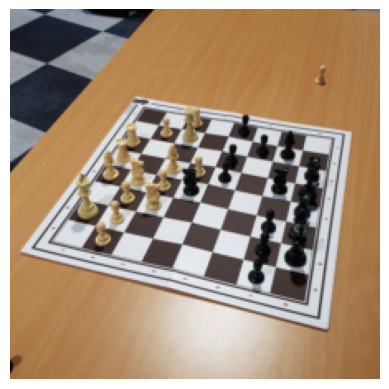

In [10]:
def convert_to_redable(labels):
    result = []
    for i in range(8):
        result_tmp = []
        for j in range(8):
            result_tmp.append(int(torch.argmax(labels[i][j])))
        result.append(result_tmp)
    return result
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            result_tmp.append(piece_dict[int(torch.argmax(labels[i][j]))])
        print(result_tmp)


for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)
    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break


## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [11]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    all_preds = all_preds.argmax(dim=-1)
    all_labels = all_labels.argmax(dim=-1)
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    return accuracy, recall, precision, f1

## Train the model

Define function to perform one iteration

In [12]:

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          batch_size = X.size(0)
          formated_pred = pred.view(batch_size, 8, 8, 13)
          #scaled_pred = model(X)
          #print("Test",formated_pred.shape,y.shape)
          #print(fomated_pred,y)
          loss = loss_fn(formated_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.append(formated_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds)
    all_labels = torch.cat(labels)
    # compute the predictions and labels:
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Accuracy:", accuracy)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [13]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [14]:
# Define loss function
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 50

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 404/404 [01:26<00:00,  4.66it/s]


Train loss: 1.15625 	 Train acc: 0.00000 	 Train recall: 0.47152 	 Train precision: 0.24199 	 Train f1: 0.27138


100%|██████████| 137/137 [00:09<00:00, 14.36it/s]


Val loss: 1.17282 	 Val acc: 0.00000 	 Val recall: 0.40831 	 Val precision: 0.20698 	 Val f1: 0.22783

Epoch 2


100%|██████████| 404/404 [01:25<00:00,  4.72it/s]


Train loss: 1.13568 	 Train acc: 0.00000 	 Train recall: 0.48220 	 Train precision: 0.24612 	 Train f1: 0.28190


100%|██████████| 137/137 [00:09<00:00, 14.30it/s]


Val loss: 1.16656 	 Val acc: 0.00000 	 Val recall: 0.46129 	 Val precision: 0.22401 	 Val f1: 0.25597

Epoch 3


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.11649 	 Train acc: 0.00000 	 Train recall: 0.50481 	 Train precision: 0.26108 	 Train f1: 0.30181


100%|██████████| 137/137 [00:09<00:00, 14.13it/s]


Val loss: 1.15548 	 Val acc: 0.00000 	 Val recall: 0.45200 	 Val precision: 0.23092 	 Val f1: 0.26168

Epoch 4


100%|██████████| 404/404 [01:25<00:00,  4.72it/s]


Train loss: 1.09881 	 Train acc: 0.00000 	 Train recall: 0.52653 	 Train precision: 0.27776 	 Train f1: 0.32230


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.14665 	 Val acc: 0.00000 	 Val recall: 0.42647 	 Val precision: 0.22791 	 Val f1: 0.25595

Epoch 5


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.08284 	 Train acc: 0.00000 	 Train recall: 0.55102 	 Train precision: 0.29379 	 Train f1: 0.34258


100%|██████████| 137/137 [00:10<00:00, 13.32it/s]


Val loss: 1.13477 	 Val acc: 0.00000 	 Val recall: 0.44468 	 Val precision: 0.24062 	 Val f1: 0.27378

Epoch 6


100%|██████████| 404/404 [01:29<00:00,  4.52it/s]


Train loss: 1.06967 	 Train acc: 0.00000 	 Train recall: 0.58348 	 Train precision: 0.31793 	 Train f1: 0.37364


100%|██████████| 137/137 [00:09<00:00, 13.76it/s]


Val loss: 1.12170 	 Val acc: 0.00000 	 Val recall: 0.44855 	 Val precision: 0.25028 	 Val f1: 0.28578

Epoch 7


100%|██████████| 404/404 [01:27<00:00,  4.64it/s]


Train loss: 1.05989 	 Train acc: 0.00000 	 Train recall: 0.61219 	 Train precision: 0.34072 	 Train f1: 0.40304


100%|██████████| 137/137 [00:09<00:00, 13.98it/s]


Val loss: 1.11288 	 Val acc: 0.00000 	 Val recall: 0.47411 	 Val precision: 0.26937 	 Val f1: 0.31084

Epoch 8


100%|██████████| 404/404 [01:27<00:00,  4.61it/s]


Train loss: 1.05298 	 Train acc: 0.00000 	 Train recall: 0.63238 	 Train precision: 0.36504 	 Train f1: 0.43232


100%|██████████| 137/137 [00:09<00:00, 13.99it/s]


Val loss: 1.10493 	 Val acc: 0.00000 	 Val recall: 0.47654 	 Val precision: 0.28327 	 Val f1: 0.32619

Epoch 9


100%|██████████| 404/404 [01:29<00:00,  4.53it/s]


Train loss: 1.04820 	 Train acc: 0.00000 	 Train recall: 0.64399 	 Train precision: 0.38385 	 Train f1: 0.45316


100%|██████████| 137/137 [00:10<00:00, 13.56it/s]


Val loss: 1.09920 	 Val acc: 0.00000 	 Val recall: 0.49024 	 Val precision: 0.29690 	 Val f1: 0.34254

Epoch 10


100%|██████████| 404/404 [01:26<00:00,  4.65it/s]


Train loss: 1.04600 	 Train acc: 0.00000 	 Train recall: 0.65505 	 Train precision: 0.40154 	 Train f1: 0.47307


100%|██████████| 137/137 [00:09<00:00, 14.09it/s]


Val loss: 1.09567 	 Val acc: 0.00000 	 Val recall: 0.49224 	 Val precision: 0.30577 	 Val f1: 0.35425

Epoch 11


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.04530 	 Train acc: 0.00000 	 Train recall: 0.67104 	 Train precision: 0.41973 	 Train f1: 0.49322


100%|██████████| 137/137 [00:09<00:00, 14.33it/s]


Val loss: 1.09661 	 Val acc: 0.00000 	 Val recall: 0.49764 	 Val precision: 0.30889 	 Val f1: 0.35804

Epoch 12


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.04407 	 Train acc: 0.00000 	 Train recall: 0.67393 	 Train precision: 0.42619 	 Train f1: 0.49988


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.09172 	 Val acc: 0.00000 	 Val recall: 0.49668 	 Val precision: 0.32036 	 Val f1: 0.36813

Epoch 13


100%|██████████| 404/404 [01:25<00:00,  4.73it/s]


Train loss: 1.04324 	 Train acc: 0.00000 	 Train recall: 0.67941 	 Train precision: 0.43766 	 Train f1: 0.51068


100%|██████████| 137/137 [00:09<00:00, 14.33it/s]


Val loss: 1.09148 	 Val acc: 0.00000 	 Val recall: 0.48604 	 Val precision: 0.31733 	 Val f1: 0.36101

Epoch 14


100%|██████████| 404/404 [01:25<00:00,  4.72it/s]


Train loss: 1.04239 	 Train acc: 0.00000 	 Train recall: 0.67902 	 Train precision: 0.44775 	 Train f1: 0.51677


100%|██████████| 137/137 [00:09<00:00, 14.15it/s]


Val loss: 1.09051 	 Val acc: 0.00000 	 Val recall: 0.50119 	 Val precision: 0.33198 	 Val f1: 0.37680

Epoch 15


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.04197 	 Train acc: 0.00000 	 Train recall: 0.68429 	 Train precision: 0.45778 	 Train f1: 0.52572


100%|██████████| 137/137 [00:09<00:00, 14.32it/s]


Val loss: 1.09121 	 Val acc: 0.00000 	 Val recall: 0.48562 	 Val precision: 0.32999 	 Val f1: 0.37167

Epoch 16


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.04183 	 Train acc: 0.00000 	 Train recall: 0.69251 	 Train precision: 0.46819 	 Train f1: 0.53634


100%|██████████| 137/137 [00:09<00:00, 14.13it/s]


Val loss: 1.09313 	 Val acc: 0.00000 	 Val recall: 0.50734 	 Val precision: 0.34275 	 Val f1: 0.38472

Epoch 17


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.04096 	 Train acc: 0.00000 	 Train recall: 0.70154 	 Train precision: 0.48139 	 Train f1: 0.54727


100%|██████████| 137/137 [00:09<00:00, 14.11it/s]


Val loss: 1.08893 	 Val acc: 0.00000 	 Val recall: 0.50167 	 Val precision: 0.34827 	 Val f1: 0.38964

Epoch 18


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.04016 	 Train acc: 0.00000 	 Train recall: 0.71051 	 Train precision: 0.49678 	 Train f1: 0.56355


100%|██████████| 137/137 [00:09<00:00, 14.29it/s]


Val loss: 1.08838 	 Val acc: 0.00000 	 Val recall: 0.50429 	 Val precision: 0.35374 	 Val f1: 0.39311

Epoch 19


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03958 	 Train acc: 0.00000 	 Train recall: 0.71065 	 Train precision: 0.50206 	 Train f1: 0.56747


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.08881 	 Val acc: 0.00000 	 Val recall: 0.50370 	 Val precision: 0.36143 	 Val f1: 0.39960

Epoch 20


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03923 	 Train acc: 0.00000 	 Train recall: 0.71766 	 Train precision: 0.51064 	 Train f1: 0.57591


100%|██████████| 137/137 [00:09<00:00, 14.27it/s]


Val loss: 1.08774 	 Val acc: 0.00000 	 Val recall: 0.52253 	 Val precision: 0.36945 	 Val f1: 0.41212

Epoch 21


100%|██████████| 404/404 [01:26<00:00,  4.70it/s]


Train loss: 1.03905 	 Train acc: 0.00000 	 Train recall: 0.72528 	 Train precision: 0.51490 	 Train f1: 0.58197


100%|██████████| 137/137 [00:09<00:00, 14.25it/s]


Val loss: 1.08999 	 Val acc: 0.00000 	 Val recall: 0.50062 	 Val precision: 0.36613 	 Val f1: 0.40315

Epoch 22


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03880 	 Train acc: 0.00000 	 Train recall: 0.72941 	 Train precision: 0.52873 	 Train f1: 0.59479


100%|██████████| 137/137 [00:09<00:00, 14.26it/s]


Val loss: 1.08849 	 Val acc: 0.00000 	 Val recall: 0.51289 	 Val precision: 0.37705 	 Val f1: 0.41504

Epoch 23


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03846 	 Train acc: 0.00000 	 Train recall: 0.74046 	 Train precision: 0.54592 	 Train f1: 0.61206


100%|██████████| 137/137 [00:09<00:00, 14.30it/s]


Val loss: 1.08822 	 Val acc: 0.00000 	 Val recall: 0.51419 	 Val precision: 0.37985 	 Val f1: 0.41981

Epoch 24


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03842 	 Train acc: 0.00000 	 Train recall: 0.74255 	 Train precision: 0.55365 	 Train f1: 0.61900


100%|██████████| 137/137 [00:09<00:00, 14.29it/s]


Val loss: 1.08689 	 Val acc: 0.00000 	 Val recall: 0.52585 	 Val precision: 0.40372 	 Val f1: 0.44088

Epoch 25


100%|██████████| 404/404 [01:26<00:00,  4.70it/s]


Train loss: 1.03771 	 Train acc: 0.00000 	 Train recall: 0.74904 	 Train precision: 0.58051 	 Train f1: 0.64039


100%|██████████| 137/137 [00:09<00:00, 14.27it/s]


Val loss: 1.08674 	 Val acc: 0.00000 	 Val recall: 0.51251 	 Val precision: 0.40197 	 Val f1: 0.43632

Epoch 26


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03756 	 Train acc: 0.00015 	 Train recall: 0.75513 	 Train precision: 0.59974 	 Train f1: 0.65524


100%|██████████| 137/137 [00:09<00:00, 14.22it/s]


Val loss: 1.08706 	 Val acc: 0.00000 	 Val recall: 0.52131 	 Val precision: 0.41222 	 Val f1: 0.44628

Epoch 27


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03725 	 Train acc: 0.00015 	 Train recall: 0.75905 	 Train precision: 0.60057 	 Train f1: 0.66012


100%|██████████| 137/137 [00:09<00:00, 14.29it/s]


Val loss: 1.08975 	 Val acc: 0.00000 	 Val recall: 0.51892 	 Val precision: 0.41330 	 Val f1: 0.44552

Epoch 28


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03736 	 Train acc: 0.00031 	 Train recall: 0.76077 	 Train precision: 0.60626 	 Train f1: 0.66473


100%|██████████| 137/137 [00:09<00:00, 14.16it/s]


Val loss: 1.08735 	 Val acc: 0.00000 	 Val recall: 0.52814 	 Val precision: 0.44046 	 Val f1: 0.46809

Epoch 29


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03688 	 Train acc: 0.00046 	 Train recall: 0.76669 	 Train precision: 0.61979 	 Train f1: 0.67565


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.08656 	 Val acc: 0.00000 	 Val recall: 0.52117 	 Val precision: 0.41831 	 Val f1: 0.45204

Epoch 30


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03704 	 Train acc: 0.00015 	 Train recall: 0.76289 	 Train precision: 0.62165 	 Train f1: 0.67569


100%|██████████| 137/137 [00:09<00:00, 14.18it/s]


Val loss: 1.08695 	 Val acc: 0.00000 	 Val recall: 0.52896 	 Val precision: 0.42454 	 Val f1: 0.45943

Epoch 31


100%|██████████| 404/404 [01:25<00:00,  4.72it/s]


Train loss: 1.03676 	 Train acc: 0.00093 	 Train recall: 0.76382 	 Train precision: 0.62622 	 Train f1: 0.67890


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.08643 	 Val acc: 0.00000 	 Val recall: 0.52547 	 Val precision: 0.42450 	 Val f1: 0.45766

Epoch 32


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.03680 	 Train acc: 0.00062 	 Train recall: 0.77348 	 Train precision: 0.64102 	 Train f1: 0.69110


100%|██████████| 137/137 [00:09<00:00, 14.30it/s]


Val loss: 1.08724 	 Val acc: 0.00000 	 Val recall: 0.53519 	 Val precision: 0.43695 	 Val f1: 0.46929

Epoch 33


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03677 	 Train acc: 0.00046 	 Train recall: 0.77226 	 Train precision: 0.63813 	 Train f1: 0.68875


100%|██████████| 137/137 [00:09<00:00, 14.27it/s]


Val loss: 1.08630 	 Val acc: 0.00000 	 Val recall: 0.53194 	 Val precision: 0.43044 	 Val f1: 0.46342

Epoch 34


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.03665 	 Train acc: 0.00062 	 Train recall: 0.77688 	 Train precision: 0.64219 	 Train f1: 0.69331


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.08649 	 Val acc: 0.00000 	 Val recall: 0.53338 	 Val precision: 0.43380 	 Val f1: 0.46776

Epoch 35


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.03657 	 Train acc: 0.00015 	 Train recall: 0.77245 	 Train precision: 0.63982 	 Train f1: 0.69048


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.08553 	 Val acc: 0.00000 	 Val recall: 0.53098 	 Val precision: 0.43537 	 Val f1: 0.46817

Epoch 36


100%|██████████| 404/404 [01:26<00:00,  4.70it/s]


Train loss: 1.03635 	 Train acc: 0.00077 	 Train recall: 0.77674 	 Train precision: 0.65692 	 Train f1: 0.70260


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.08576 	 Val acc: 0.00000 	 Val recall: 0.53817 	 Val precision: 0.44490 	 Val f1: 0.47758

Epoch 37


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03635 	 Train acc: 0.00155 	 Train recall: 0.77633 	 Train precision: 0.66119 	 Train f1: 0.70498


100%|██████████| 137/137 [00:09<00:00, 14.34it/s]


Val loss: 1.08641 	 Val acc: 0.00000 	 Val recall: 0.53042 	 Val precision: 0.45268 	 Val f1: 0.47901

Epoch 38


100%|██████████| 404/404 [01:25<00:00,  4.72it/s]


Train loss: 1.03653 	 Train acc: 0.00201 	 Train recall: 0.77421 	 Train precision: 0.66175 	 Train f1: 0.70563


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.08650 	 Val acc: 0.00000 	 Val recall: 0.53241 	 Val precision: 0.44381 	 Val f1: 0.47441

Epoch 39


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03635 	 Train acc: 0.00495 	 Train recall: 0.77740 	 Train precision: 0.67106 	 Train f1: 0.71330


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.08636 	 Val acc: 0.00000 	 Val recall: 0.54240 	 Val precision: 0.45056 	 Val f1: 0.48256

Epoch 40


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03615 	 Train acc: 0.00433 	 Train recall: 0.78081 	 Train precision: 0.68069 	 Train f1: 0.72028


100%|██████████| 137/137 [00:09<00:00, 14.32it/s]


Val loss: 1.08660 	 Val acc: 0.00000 	 Val recall: 0.52860 	 Val precision: 0.45115 	 Val f1: 0.47912

Epoch 41


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03609 	 Train acc: 0.00449 	 Train recall: 0.77521 	 Train precision: 0.67520 	 Train f1: 0.71519


100%|██████████| 137/137 [00:09<00:00, 14.13it/s]


Val loss: 1.08523 	 Val acc: 0.00000 	 Val recall: 0.53535 	 Val precision: 0.45516 	 Val f1: 0.48393

Epoch 42


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03613 	 Train acc: 0.00325 	 Train recall: 0.77595 	 Train precision: 0.67381 	 Train f1: 0.71488


100%|██████████| 137/137 [00:09<00:00, 14.30it/s]


Val loss: 1.08619 	 Val acc: 0.00000 	 Val recall: 0.52912 	 Val precision: 0.45275 	 Val f1: 0.47946

Epoch 43


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03601 	 Train acc: 0.00882 	 Train recall: 0.77858 	 Train precision: 0.68202 	 Train f1: 0.72236


100%|██████████| 137/137 [00:09<00:00, 14.12it/s]


Val loss: 1.08511 	 Val acc: 0.00000 	 Val recall: 0.52348 	 Val precision: 0.45443 	 Val f1: 0.47891

Epoch 44


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03594 	 Train acc: 0.01284 	 Train recall: 0.78153 	 Train precision: 0.68910 	 Train f1: 0.72729


100%|██████████| 137/137 [00:09<00:00, 14.33it/s]


Val loss: 1.08842 	 Val acc: 0.00000 	 Val recall: 0.53178 	 Val precision: 0.47118 	 Val f1: 0.49421

Epoch 45


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03592 	 Train acc: 0.01160 	 Train recall: 0.78174 	 Train precision: 0.69776 	 Train f1: 0.73297


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.08583 	 Val acc: 0.00000 	 Val recall: 0.52429 	 Val precision: 0.45320 	 Val f1: 0.47991

Epoch 46


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03581 	 Train acc: 0.01222 	 Train recall: 0.77982 	 Train precision: 0.69497 	 Train f1: 0.72986


100%|██████████| 137/137 [00:09<00:00, 14.30it/s]


Val loss: 1.08537 	 Val acc: 0.00000 	 Val recall: 0.54488 	 Val precision: 0.47244 	 Val f1: 0.49861

Epoch 47


100%|██████████| 404/404 [01:25<00:00,  4.70it/s]


Train loss: 1.03558 	 Train acc: 0.00835 	 Train recall: 0.78371 	 Train precision: 0.69951 	 Train f1: 0.73420


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.08471 	 Val acc: 0.00000 	 Val recall: 0.52718 	 Val precision: 0.45708 	 Val f1: 0.48134

Epoch 48


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03557 	 Train acc: 0.01377 	 Train recall: 0.78098 	 Train precision: 0.70403 	 Train f1: 0.73511


100%|██████████| 137/137 [00:09<00:00, 14.28it/s]


Val loss: 1.08620 	 Val acc: 0.00000 	 Val recall: 0.52970 	 Val precision: 0.46665 	 Val f1: 0.48991

Epoch 49


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03578 	 Train acc: 0.01160 	 Train recall: 0.78173 	 Train precision: 0.70209 	 Train f1: 0.73475


100%|██████████| 137/137 [00:09<00:00, 14.31it/s]


Val loss: 1.08460 	 Val acc: 0.00000 	 Val recall: 0.53649 	 Val precision: 0.47410 	 Val f1: 0.49592

Epoch 50


100%|██████████| 404/404 [01:25<00:00,  4.71it/s]


Train loss: 1.03584 	 Train acc: 0.01006 	 Train recall: 0.78309 	 Train precision: 0.70581 	 Train f1: 0.73779


100%|██████████| 137/137 [00:09<00:00, 14.33it/s]


Val loss: 1.08782 	 Val acc: 0.00000 	 Val recall: 0.52543 	 Val precision: 0.44178 	 Val f1: 0.47177
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [15]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

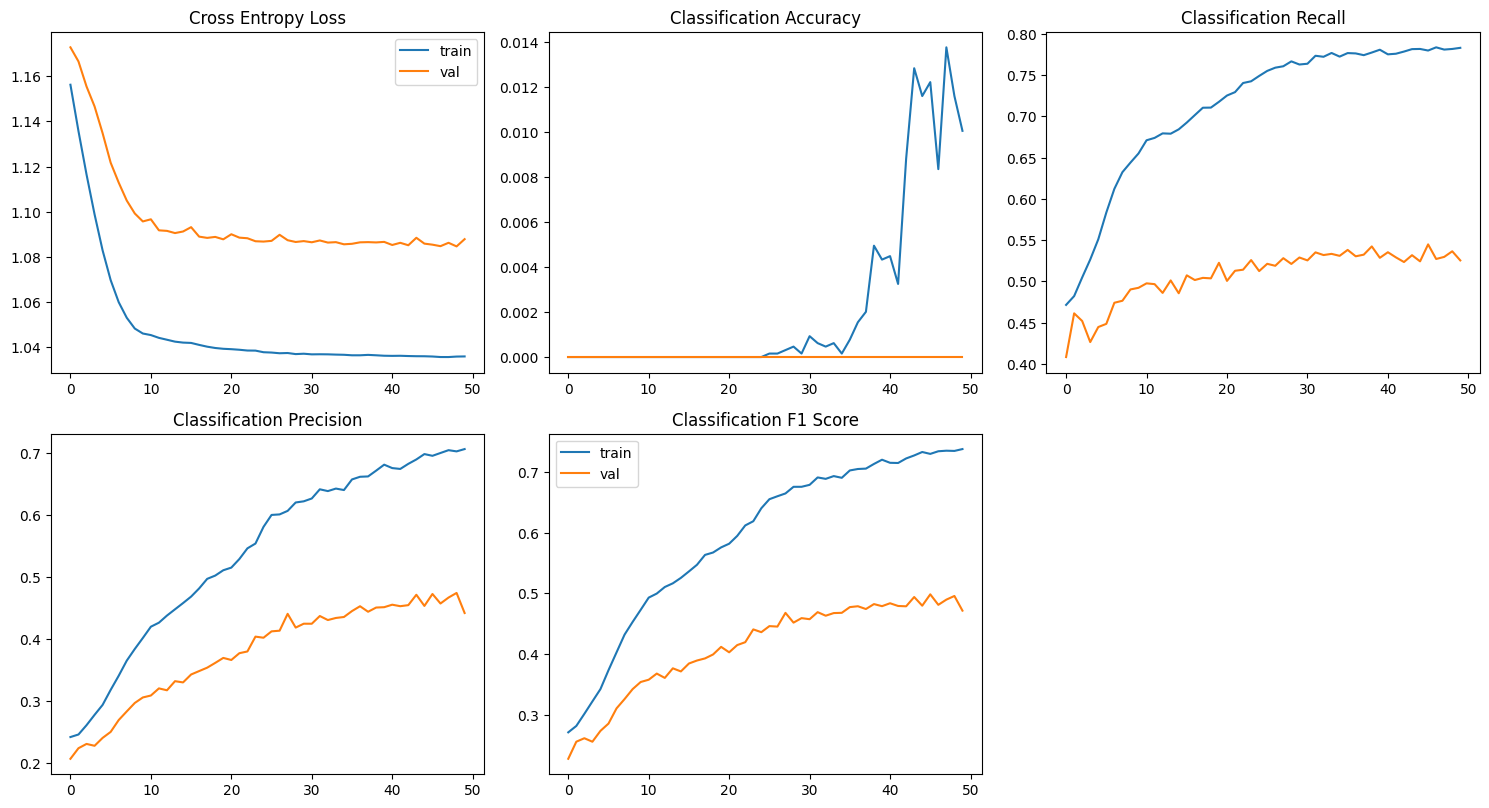

In [16]:
plotTrainingHistory(train_history, val_history)
del train_history,val_history

## Test the model

Evaluate the model in the test set

In [17]:
torch.cuda.empty_cache()
#del valid_dataset, valid_dataloader, train_dataset, train_dataloader
test_dataset = ChessDataset('..', 'test', data_in)
batch_size = 16
num_workers = 0 # how many processes are used to load the data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Number of test images: 2129


In [18]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory

#load the best model
#del model
#model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])

def test(dataloader):
    preds = []
    labels = []
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            batch_size = X.size(0)
            formated_pred = pred.view(batch_size, 8, 8, 13)
            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            preds.extend(formated_pred.cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.extend(y.cpu())
        all_preds = torch.cat(preds)
        all_labels = torch.cat(labels)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

100%|██████████| 134/134 [00:09<00:00, 13.74it/s]


Test accuracy: 0.268, Test recall: 0.535, Test precision: 0.453, Test f1: 0.483


  0%|          | 0/134 [00:00<?, ?it/s]

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']
Test : torch.Size([8, 8, 13])
['R', 'N', 'R', 'R', 'R', 'R', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', 'N', '-', '-']
['-', '-', '-', '-', '-', '-', '-', 'B']
['-', '-', '-', '-', '-', '-', '-', 'q']
['-', '-', 'n', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'r', 'k', 'q', 'r', 'n', 'r']


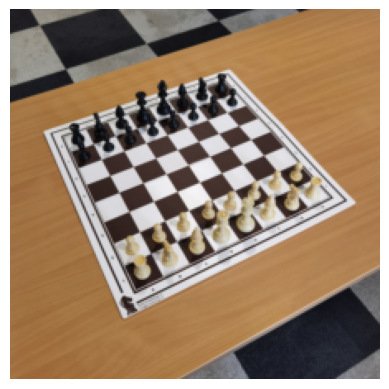

  1%|          | 1/134 [00:00<00:22,  5.92it/s]

['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', '-']
['-', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Test : torch.Size([8, 8, 13])
['R', 'K', 'R', 'R', 'R', 'K', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', 'P', '-']
['-', '-', 'Q', 'P', '-', 'N', '-', 'P']
['B', '-', '-', '-', 'P', 'P', 'b', 'Q']
['-', '-', 'b', '-', 'n', '-', '-', '-']
['p', '-', 'n', 'p', 'k', 'n', '-', '-']
['-', 'b', 'p', '-', '-', '-', 'p', 'p']
['r', 'k', 'r', 'r', 'r', '-', '-', 'r']


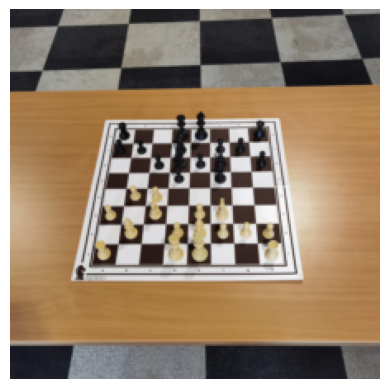

  1%|▏         | 2/134 [00:00<00:22,  5.92it/s]

['-', '-', '-', 'R', '-', '-', '-', 'R']
['K', 'P', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', 'n', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Test : torch.Size([8, 8, 13])
['R', '-', 'R', 'R', '-', '-', '-', 'R']
['P', 'B', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'B', 'N', '-', 'P']
['N', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', 'p', '-']
['p', 'n', 'n', '-', '-', 'n', '-', 'p']
['-', 'p', 'p', 'b', 'n', '-', 'p', '-']
['r', 'k', 'k', 'r', '-', '-', '-', 'r']


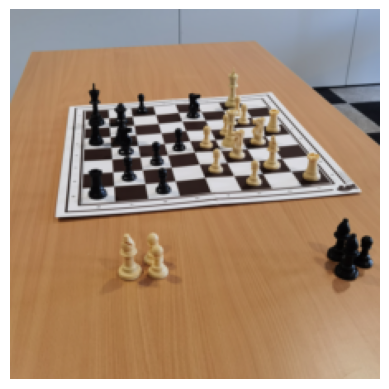

  2%|▏         | 3/134 [00:00<00:22,  5.92it/s]

['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', '-', '-', 'n', '-']
['-', 'K', 'N', 'P', '-', '-', '-', 'P']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', 'p', 'P', 'p', '-']
['p', '-', '-', 'r', '-', 'p', '-', 'p']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', 'r']
Test : torch.Size([8, 8, 13])
['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', 'P', '-', '-', '-', 'P', '-']
['-', 'Q', 'R', 'P', '-', '-', '-', 'P']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', 'p', 'P', 'p', '-']
['p', '-', '-', 'p', '-', 'p', '-', 'p']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', 'k']


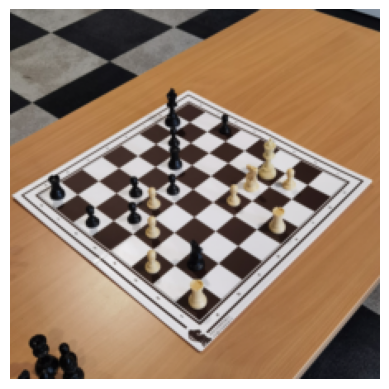

  3%|▎         | 4/134 [00:00<00:21,  6.03it/s]

['-', '-', '-', '-', '-', '-', '-', 'R']
['K', 'P', '-', '-', 'R', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', 'r', 'N', 'n', 'P', '-']
['-', '-', '-', '-', '-', 'P', 'p', '-']
['p', 'r', '-', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']
Test : torch.Size([8, 8, 13])
['-', '-', '-', '-', '-', '-', '-', 'R']
['P', 'P', '-', '-', 'R', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', 'P']
['-', '-', '-', 'K', 'P', 'B', 'P', '-']
['-', '-', '-', '-', 'p', 'N', 'p', '-']
['p', 'q', '-', '-', '-', 'r', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


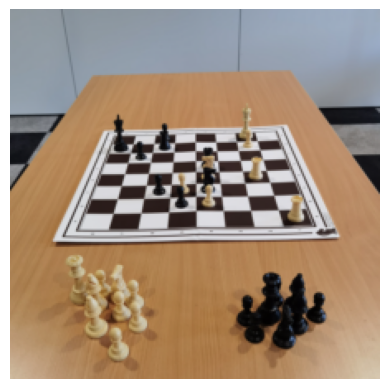

  4%|▎         | 5/134 [00:00<00:20,  6.15it/s]

['-', 'K', 'R', '-', '-', '-', '-', '-']
['-', 'P', '-', '-', 'R', '-', '-', '-']
['-', 'N', '-', '-', '-', '-', '-', '-']
['-', 'n', '-', '-', '-', '-', 'r', '-']
['-', '-', '-', '-', 'r', '-', 'p', '-']
['-', '-', '-', '-', '-', 'p', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']
Test : torch.Size([8, 8, 13])
['-', 'K', 'R', '-', '-', '-', '-', '-']
['-', 'P', '-', '-', 'R', '-', '-', '-']
['-', 'Q', '-', '-', '-', '-', '-', '-']
['q', 'N', '-', '-', '-', '-', 'B', '-']
['-', '-', '-', '-', 'p', '-', 'p', '-']
['-', '-', 'p', '-', '-', 'r', '-', '-']
['-', '-', 'k', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', '-', '-']


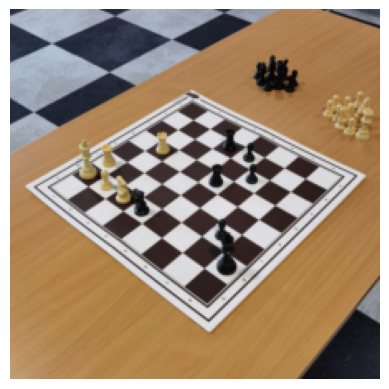

  4%|▎         | 5/134 [00:00<00:25,  5.05it/s]


In [19]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    tests = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            print_readable_board(y[0])
            print("Test :",pred[0].view( 8, 8, 13).shape)
            print_readable_board(pred[0].view( 8, 8, 13))
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            tests -= 1
            if tests < 0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?